In [1]:
import pickle
import numpy as np
from scipy import stats
import os
import torch
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
def mean_corr(feature):
    # feature = torch.from_numpy(feature)
    rho,_ = stats.pearsonr(feature,feature)
    corr = torch.from_numpy(rho)
    mask = torch.triu(torch.ones(corr.shape[0], corr.shape[1]),diagonal=1)
    mean_corr = torch.sum(abs(corr) * mask) / torch.sum(mask)

    return mean_corr

In [15]:
def mean_spearman(feature):
    rho, pval = stats.spearmanr(feature)
    corr = torch.from_numpy(rho)
    mask = torch.triu(torch.ones(corr.shape[0], corr.shape[1]),diagonal=1)
    mean_spearman = torch.sum(abs(corr) * mask) / torch.sum(mask)

    return mean_spearman

In [120]:
from sklearn import metrics

def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))
    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]
    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})
    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()

In [17]:
savedir = 'checkpoints'
feature_file = os.path.join(savedir, 'features_baseline.pickle')

with open(feature_file, 'rb') as fh:
    _, _, _, \
    _, _, _, \
    scores, _ = pickle.load(fh)

scores_basline = -scores

In [18]:
savedir = 'checkpoints'
feature_file = os.path.join(savedir, 'features_kld.pickle')

with open(feature_file, 'rb') as fh:
    _, _, _, \
    _, _, _, \
    scores, _ = pickle.load(fh)

scores_kld = -scores

In [3]:
savedir = 'checkpoints/SAKE_KLD0.1/512/random_5736'
feature_file = os.path.join(savedir, 'features_zero.pickle')

In [5]:
with open(feature_file, 'rb') as fh:
    predicted_features_gallery, binary_features_gallery, gt_labels_gallery, \
    predicted_features_query, binary_features_query, gt_labels_query, \
    scores, binary_scores = pickle.load(fh)

baseline

In [92]:
print(mean_spearman(predicted_features_query))
print(mean_spearman(predicted_features_gallery))

tensor(0.1498, dtype=torch.float64)
tensor(0.1155, dtype=torch.float64)


In [94]:
print(stats.shapiro(predicted_features_query))
print(stats.shapiro(predicted_features_gallery))

ShapiroResult(statistic=0.983380913734436, pvalue=0.0)
ShapiroResult(statistic=0.9724953770637512, pvalue=0.0)


In [116]:
ks_all = [stats.ks_2samp(predicted_features_query[:,i], predicted_features_gallery[:,i])[1] for i in range(predicted_features_query.shape[1])]
sum(ks_all)

0.3437956846700535

kld

In [107]:
print(mean_spearman(predicted_features_query))
print(mean_spearman(predicted_features_gallery))

tensor(0.1268, dtype=torch.float64)
tensor(0.1041, dtype=torch.float64)


In [108]:
print(stats.shapiro(predicted_features_query))
print(stats.shapiro(predicted_features_gallery))

ShapiroResult(statistic=0.9599615335464478, pvalue=0.0)
ShapiroResult(statistic=0.9411956667900085, pvalue=0.0)


In [113]:
ks_all = [stats.ks_2samp(predicted_features_query[:,i], predicted_features_gallery[:,i])[1] for i in range(predicted_features_query.shape[1])]
sum(ks_all)

0.523017507869232

In [119]:
ks_all = [stats.ks_2samp(predicted_features_query[:,i], predicted_features_gallery[:,i])[1] for i in range(predicted_features_query.shape[1])]
sum(ks_all)

0.5226299999714424

# Distance

In [19]:
matrix_query = np.expand_dims(gt_labels_query,1).repeat(len(gt_labels_gallery), axis=1)
matrix_gallery = np.expand_dims(gt_labels_gallery,0).repeat(len(gt_labels_query), axis=0)
pair_mask = matrix_query == matrix_gallery
scores_baseline_flatten = scores_basline.flatten()[::10000]
pair_scores_baseline_flatten = scores_basline[pair_mask].flatten()[::1000]
scores_kld_flatten = scores_kld.flatten()[::10000]
pair_scores_kld_flatten = scores_kld[pair_mask].flatten()[::1000]

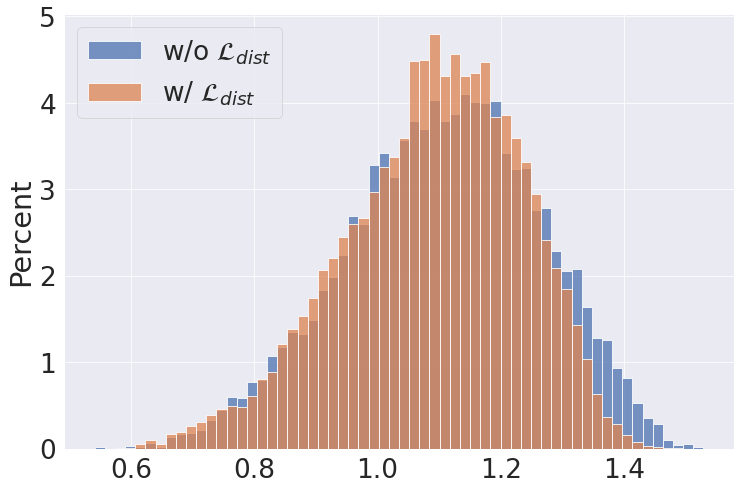

In [20]:
sns.set(style="darkgrid")
sns.set_context("paper", font_scale=3, rc={"lines.linewidth": 3, "lines.markersize": 10})
fig, ax = plt.subplots(figsize=(12, 8))
bins = np.histogram_bin_edges(pair_scores_baseline_flatten, bins=60)
colors = sns.color_palette()
sns.histplot(pair_scores_baseline_flatten, ax=ax, color=colors[0], stat='percent', bins=bins)
sns.histplot(pair_scores_kld_flatten, ax=ax, color=colors[1], stat='percent', bins=bins)
plt.legend(labels=['w/o $\mathcal{L}_{dist}$', 'w/ $\mathcal{L}_{dist}$'], loc='upper left')
plt.savefig('paired_dist.pdf', format='pdf')

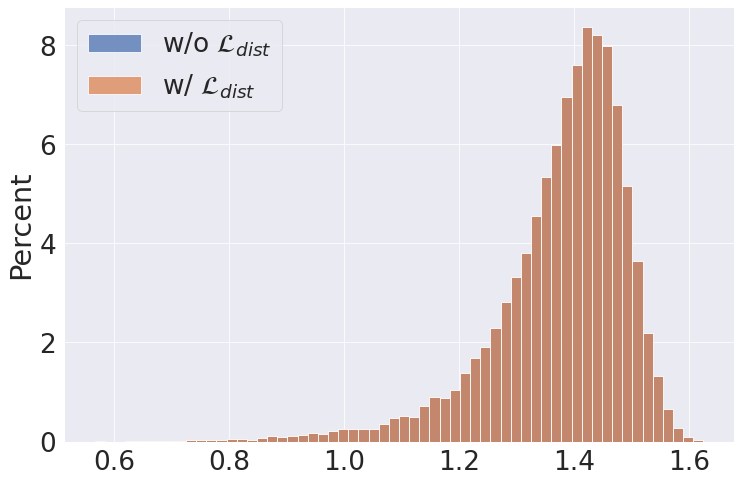

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
bins = np.histogram_bin_edges(scores_baseline_flatten, bins=60)
sns.histplot(scores_baseline_flatten, ax=ax, color=colors[0], bins=bins, stat='percent')
sns.histplot(scores_kld_flatten, ax=ax, color=colors[1], bins=bins, stat='percent')
plt.legend(labels=['w/o $\mathcal{L}_{dist}$', 'w/ $\mathcal{L}_{dist}$'])
plt.savefig('unpaired_dist.pdf', format='pdf')